<a href="https://colab.research.google.com/github/parniang/PASS/blob/main/Task_Dr_Ahmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

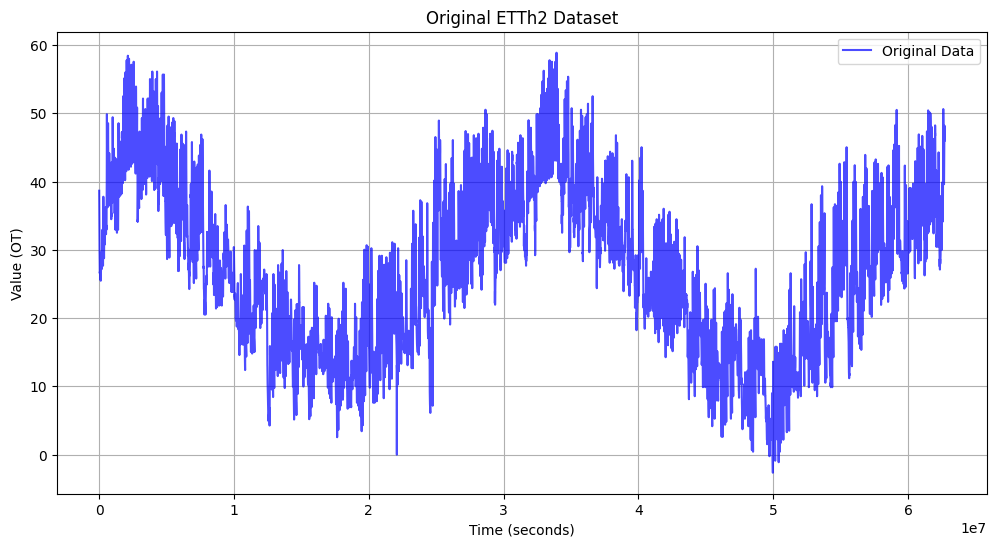

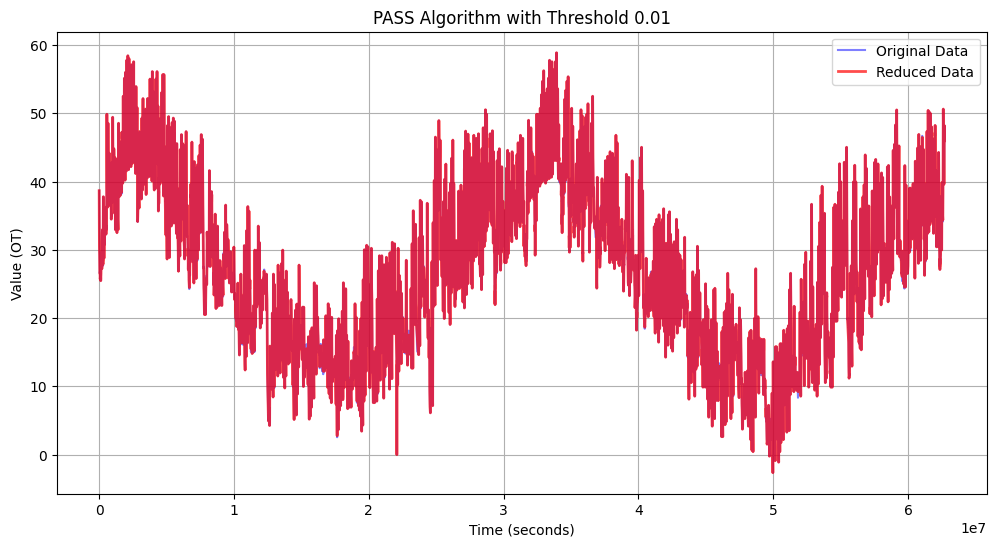

Metrics for PASS with Threshold 0.01:
MSE: 0.09033763328373155
SSIM: 0.9933014225879139
DSSIM: 0.006698577412086126
PSNR: 45.840226212892645
APScore (%): 99.9360807458871
Running Time (sec): 0.007672786712646484
Sampled Data Points: 6159


In [15]:
import pandas as pd
import numpy as np
import time
from math import log10
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

!cp /content/ETTh2.csv /content/sample_data/
file_path = '/content/sample_data/ETTh2.csv'
df = pd.read_csv(file_path)

#file_path = '/content/ETTh2.csv'
#df = pd.read_csv(file_path)


df["date"] = pd.to_datetime(df["date"])
df["time"] = (df["date"] - df["date"].iloc[0]).dt.total_seconds()
df = df.rename(columns={"OT": "value"})

def pass_algorithm(data, theta):
    windows = []
    if len(data) <= 2:
        windows.append(data.index.tolist())
        return windows

    current_window = [0, 1]
    last_angle = np.degrees(
        np.arctan2(data["value"].iloc[1] - data["value"].iloc[0],
                   data["time"].iloc[1] - data["time"].iloc[0])
    )

    for i in range(2, len(data)):
        dx = data["time"].iloc[i] - data["time"].iloc[current_window[-1]]
        dy = data["value"].iloc[i] - data["value"].iloc[current_window[-1]]
        current_angle = np.degrees(np.arctan2(dy, dx))
        angle_diff = (current_angle - last_angle + 180) % 360 - 180

        if abs(angle_diff) > theta:
            windows.append(current_window)
            current_window = [current_window[-1], i]
            last_angle = np.degrees(
                np.arctan2(
                    data["value"].iloc[i] - data["value"].iloc[current_window[0]],
                    data["time"].iloc[i] - data["time"].iloc[current_window[0]]
                )
            )
        else:
            current_window.append(i)

    if current_window:
        windows.append(current_window)
    return windows

def reduce_dataset(data, windows):
    selected_indices = set()
    for window in windows:
        selected_indices.add(window[0])
        selected_indices.add(window[-1])
    selected_indices = sorted(list(selected_indices))
    return data.iloc[selected_indices]

def evaluate_reduction(original_data, reduced_data):
    start_time = time.time()
    interpolated_values = np.interp(original_data["time"], reduced_data["time"], reduced_data["value"])
    mse = mean_squared_error(original_data["value"], interpolated_values)
    ssim_val, _ = ssim(
        original_data["value"],
        interpolated_values,
        data_range=original_data["value"].max() - original_data["value"].min(),
        full=True
    )
    dssim = 1 - ssim_val
    psnr = 10 * log10(original_data["value"].max()**2 / mse) if mse > 0 else float('inf')
    apscore = (1 - mse / (original_data["value"].var())) * 100
    running_time = time.time() - start_time
    sampled_points = len(reduced_data)
    return {
        "MSE": mse,
        "SSIM": ssim_val,
        "DSSIM": dssim,
        "PSNR": psnr,
        "APScore (%)": apscore,
        "Running Time (sec)": running_time,
        "Sampled Data Points": sampled_points
    }

threshold_theta = 0.01
windows = pass_algorithm(df, threshold_theta)
reduced_df = reduce_dataset(df, windows)

plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["value"], color="blue", label="Original Data", alpha=0.7)
plt.title("Original ETTh2 Dataset")
plt.xlabel("Time (seconds)")
plt.ylabel("Value (OT)")
plt.legend()
plt.grid(True)
plt.show()

metrics = evaluate_reduction(df, reduced_df)

plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["value"], color="blue", label="Original Data", alpha=0.5)
plt.plot(reduced_df["time"], reduced_df["value"], color="red", label="Reduced Data", alpha=0.7, linewidth=2)
plt.title(f"PASS Algorithm with Threshold {threshold_theta}")
plt.xlabel("Time (seconds)")
plt.ylabel("Value (OT)")
plt.legend()
plt.grid(True)
plt.show()


print("Metrics for PASS with Threshold 0.01:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


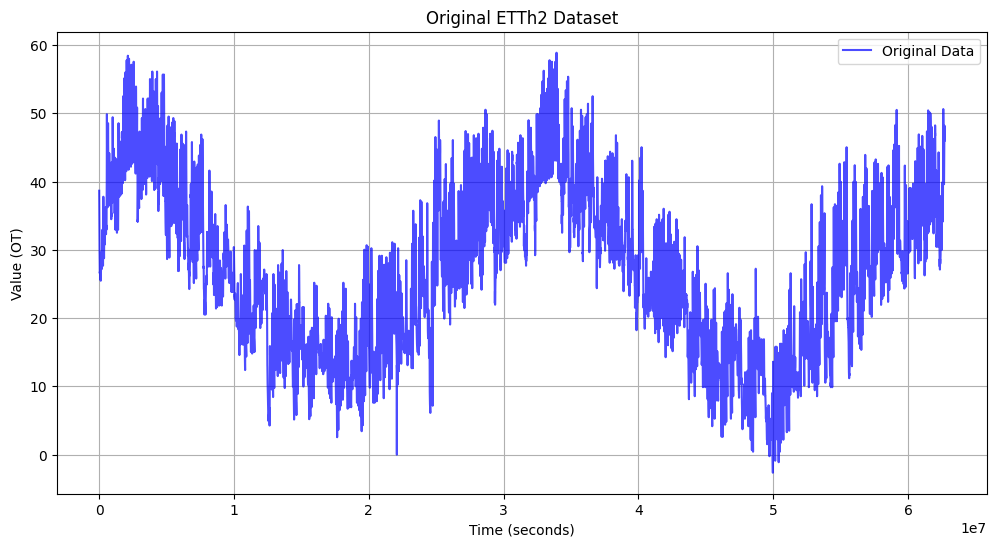

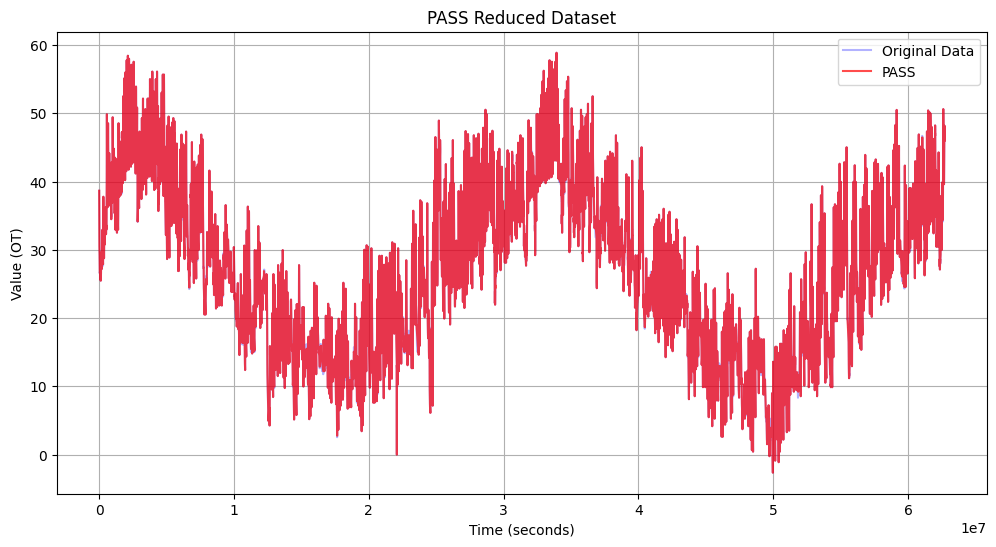

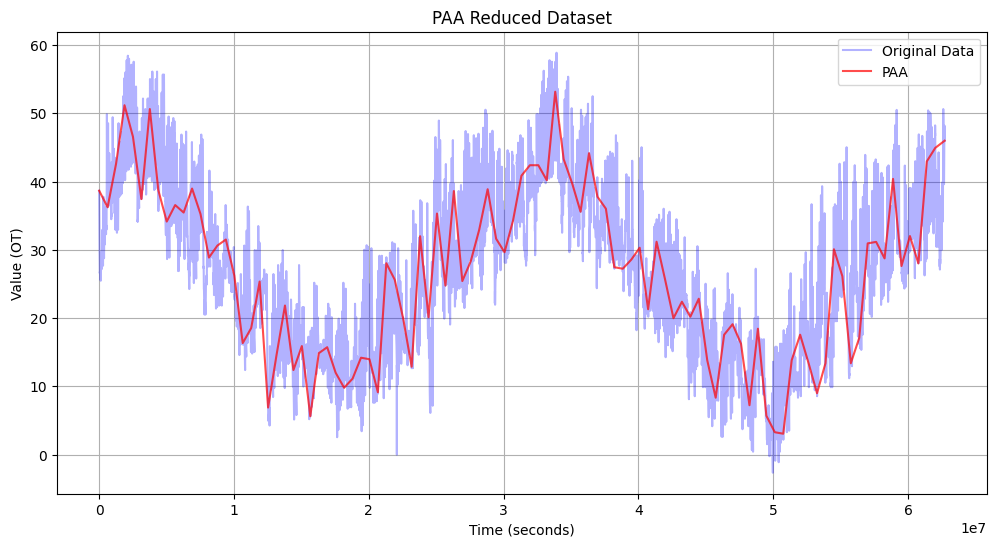

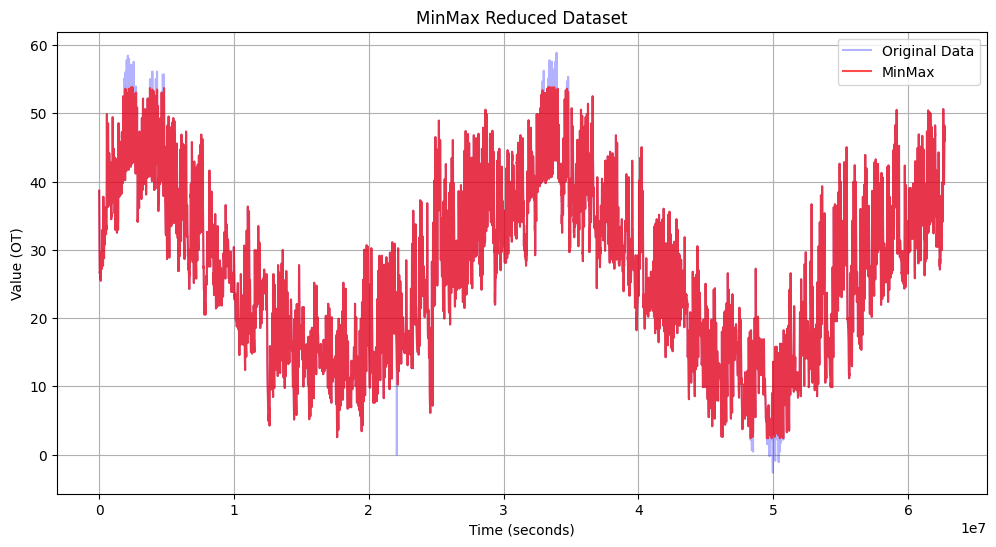

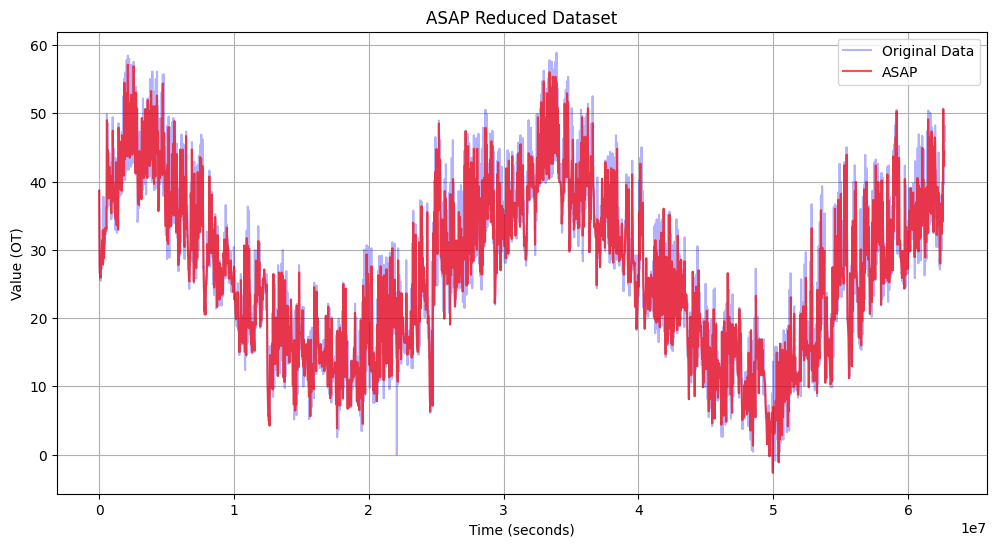

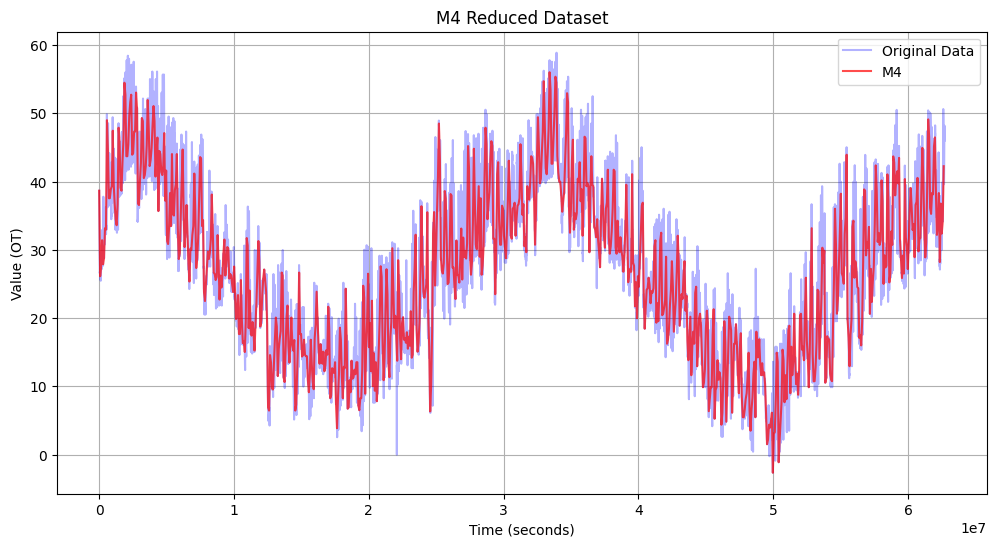

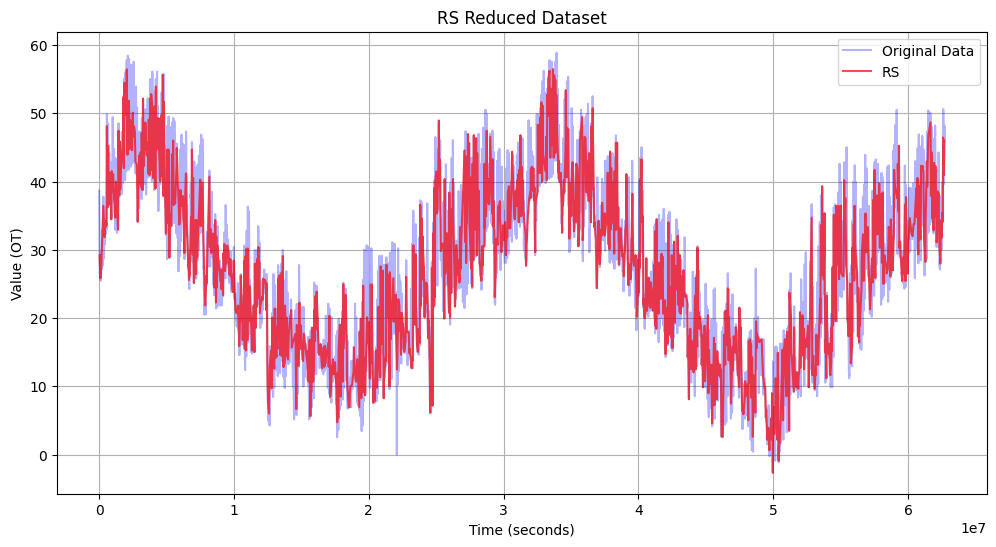

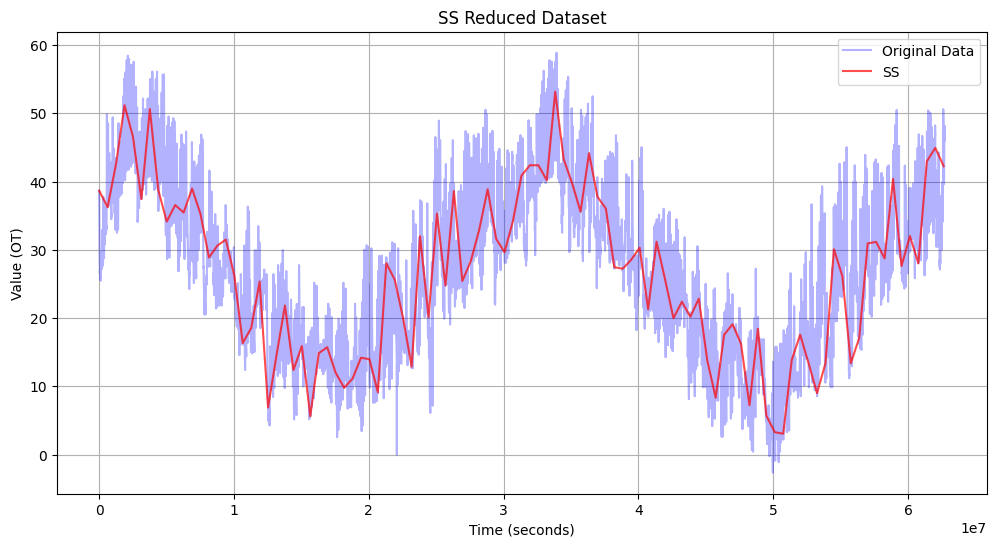

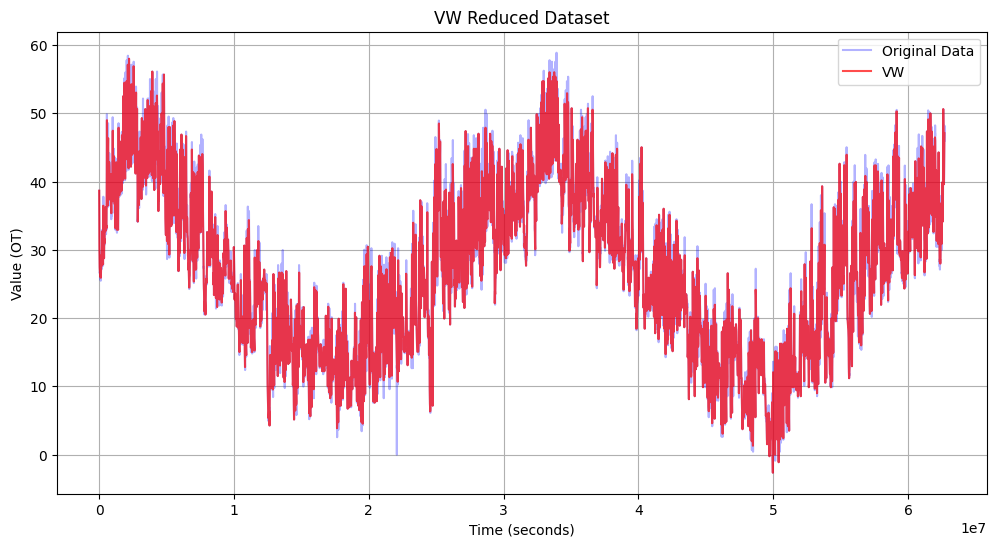

Reduction Method Metrics: 
                            PASS         PAA        MinMax         ASAP  \
MSE                     0.090338   38.333423      0.090082     6.658155   
SSIM                    0.993301    0.578231      0.995638     0.775726   
DSSIM                   0.006699    0.421769      0.004362     0.224274   
PSNR                   45.840226   19.563137     45.852511    27.165374   
APScore (%)            99.936081   72.876821     99.936261    95.288959   
Running Time (sec)      0.004037    0.002486      0.002592     0.002446   
Sampled Data Points  6159.000000  101.000000  17247.000000  1742.000000   

                             M4           RS          SS           VW  
MSE                   23.736009    16.383034   38.031079     1.140170  
SSIM                   0.600050     0.694219    0.578331     0.932998  
DSSIM                  0.399950     0.305781    0.421669     0.067002  
PSNR                  21.644836    23.254970   19.597527    34.829218  
APScore (%) 

In [16]:
import pandas as pd
import numpy as np
import time
from math import log10
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

#file_path = '/content/ETTh2.csv'
#df = pd.read_csv(file_path)

!cp /content/ETTh2.csv /content/sample_data/
file_path = '/content/sample_data/ETTh2.csv'
df = pd.read_csv(file_path)


df["date"] = pd.to_datetime(df["date"])
df["time"] = (df["date"] - df["date"].iloc[0]).dt.total_seconds()
df = df.rename(columns={"OT": "value"})


def pass_algorithm(data, theta):
    windows = []
    if len(data) <= 2:
        windows.append(data.index.tolist())
        return windows

    current_window = [0, 1]
    last_angle = np.degrees(
        np.arctan2(data["value"].iloc[1] - data["value"].iloc[0],
                   data["time"].iloc[1] - data["time"].iloc[0])
    )

    for i in range(2, len(data)):
        dx = data["time"].iloc[i] - data["time"].iloc[current_window[-1]]
        dy = data["value"].iloc[i] - data["value"].iloc[current_window[-1]]
        current_angle = np.degrees(np.arctan2(dy, dx))
        angle_diff = (current_angle - last_angle + 180) % 360 - 180

        if abs(angle_diff) > theta:
            windows.append(current_window)
            current_window = [current_window[-1], i]
            last_angle = np.degrees(
                np.arctan2(
                    data["value"].iloc[i] - data["value"].iloc[current_window[0]],
                    data["time"].iloc[i] - data["time"].iloc[current_window[0]]
                )
            )
        else:
            current_window.append(i)

    if current_window:
        windows.append(current_window)
    return windows

def reduce_dataset(data, windows):
    selected_indices = set()
    for window in windows:
        selected_indices.add(window[0])
        selected_indices.add(window[-1])
    selected_indices = sorted(list(selected_indices))
    return data.iloc[selected_indices]


def paa_reduction(data, num_segments):
    segment_size = len(data) // num_segments
    reduced_indices = [i * segment_size for i in range(num_segments)] + [len(data) - 1]
    return data.iloc[sorted(set(reduced_indices))]

def minmax_reduction(data, threshold):
    reduced_data = data[(data["value"] >= data["value"].min() + threshold) &
                        (data["value"] <= data["value"].max() - threshold)]
    return reduced_data

def asap_reduction(data):
    return data.iloc[::10]

def m4_reduction(data):
    return data.iloc[::20]

def rs_reduction(data):
    return data.sample(frac=0.1).sort_index()

def ss_reduction(data):
    step = max(1, len(data) // 100)
    return data.iloc[::step]

def vw_reduction(data, threshold):
    return data.iloc[::5]


def evaluate_reduction(original_data, reduced_data):
    start_time = time.time()
    interpolated_values = np.interp(original_data["time"], reduced_data["time"], reduced_data["value"])
    mse = mean_squared_error(original_data["value"], interpolated_values)
    ssim_val, _ = ssim(
        original_data["value"],
        interpolated_values,
        data_range=original_data["value"].max() - original_data["value"].min(),
        full=True
    )
    dssim = 1 - ssim_val
    psnr = 10 * log10(original_data["value"].max()**2 / mse) if mse > 0 else float('inf')
    apscore = (1 - mse / (original_data["value"].var())) * 100
    running_time = time.time() - start_time
    sampled_points = len(reduced_data)
    return {
        "MSE": mse,
        "SSIM": ssim_val,
        "DSSIM": dssim,
        "PSNR": psnr,
        "APScore (%)": apscore,
        "Running Time (sec)": running_time,
        "Sampled Data Points": sampled_points
    }


num_segments_paa = 100
minmax_threshold = 5
vw_threshold = 0.2
threshold_theta = 0.01

methods = {
    "PASS": lambda data: reduce_dataset(data, pass_algorithm(data, threshold_theta)),
    "PAA": lambda data: paa_reduction(data, num_segments_paa),
    "MinMax": lambda data: minmax_reduction(data, minmax_threshold),
    "ASAP": asap_reduction,
    "M4": m4_reduction,
    "RS": rs_reduction,
    "SS": ss_reduction,
    "VW": lambda data: vw_reduction(data, vw_threshold),
}


results = {}
for method_name, method_function in methods.items():
    reduced_data = method_function(df)
    results[method_name] = evaluate_reduction(df, reduced_data)


results_df = pd.DataFrame(results).T
results_df = results_df.transpose()


plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["value"], color="blue", label="Original Data", alpha=0.7)
plt.title("Original ETTh2 Dataset")
plt.xlabel("Time (seconds)")
plt.ylabel("Value (OT)")
plt.legend()
plt.grid(True)
plt.show()


for method_name, method_function in methods.items():
    reduced_data = method_function(df)
    plt.figure(figsize=(12, 6))
    plt.plot(df["time"], df["value"], color="blue", label="Original Data", alpha=0.3)
    plt.plot(reduced_data["time"], reduced_data["value"], label=method_name, alpha=0.7, color="red")
    plt.title(f"{method_name} Reduced Dataset")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Value (OT)")
    plt.legend()
    plt.grid(True)
    plt.show()


print("Reduction Method Metrics: ")
print(results_df)
